#  Генерация текста с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


## Задачи для совместного разбора

1\. Рассмотрите основные шаги обучения модели для генерации текста с использованием RNN.

![text gen](https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png)

In [1]:
import torch as th
import torch.nn as nn

In [2]:
batch_size = 16
seq_len = 5
x = th.randint(0, 10, size=(batch_size, seq_len))
x.shape

torch.Size([16, 5])

In [3]:
embedding = nn.Embedding(num_embeddings=10, embedding_dim=32)
x_e = embedding(x)
x_e.shape

torch.Size([16, 5, 32])

In [4]:
hidden_size=15
rnn = nn.RNN(input_size=32, hidden_size=15, batch_first=True)

out, h = rnn(x_e)
out.shape, h.shape

(torch.Size([16, 5, 15]), torch.Size([1, 16, 15]))

In [5]:
out[0].shape

torch.Size([5, 15])

In [6]:
# out[0][0] чтобы предсказать следующий токен

In [7]:
x[:,:-1][:4]

tensor([[8, 7, 0, 1],
        [7, 7, 4, 0],
        [8, 5, 0, 5],
        [9, 0, 5, 2]])

In [8]:
x_train = x[:,:-1]
x_train_e = embedding(x_train)
out, h = rnn(x_train_e)
out.shape

torch.Size([16, 4, 15])

In [9]:
out_2d = out.reshape(16 * 4, 15)
out_2d.shape

torch.Size([64, 15])

In [10]:
fc = nn.Linear(hidden_size, 10)
fc(out_2d).shape

torch.Size([64, 10])

In [11]:
# ignore index = 0 (pad_index) (crossentropyloss)

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`. Выведите на экран количество токенов в полученном словаре.

- [x] Проверено на семинаре

In [12]:
import pandas as pd

df = pd.read_csv('pets_ru_en.csv')
df.head()

,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en


In [13]:
df = df.drop_duplicates(subset='имя', keep='first')

In [14]:
from torchtext.vocab import build_vocab_from_iterator

corpus = []
for name in df['имя']:
    corpus.append(list(name.lower()))

vocab = build_vocab_from_iterator(corpus, specials=['pad', 'sos', 'eos'])

In [15]:
len(vocab.get_stoi())

63

<p class="task" id="2"></p>

2\. Создайте класс `PetsGenDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами) и добавьте в начало каждого набора индекс `<SOS>`, а в конец - индекс токена `<EOS>`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)` в соответствии с приведенным рисунком. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

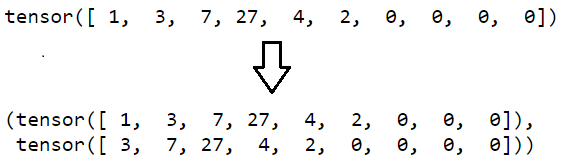

- [x] Проверено на семинаре

In [73]:
from torch.utils.data import Dataset
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator

class PetsGenDataset(Dataset):
    def __init__(self, df, vocab):
      self.df = list(df['имя'].map(lambda x: list(str(x.lower()))))
      self.vocab = vocab
      self.transform = T.Sequential(
          T.AddToken('sos', begin=True),
          T.AddToken('eos', begin=False),
          T.VocabTransform(vocab),
          T.ToTensor(0),
          T.PadTransform(max_length=self.get_max_len() + 1, pad_value=0)
      )

    def __getitem__(self, idx):
      t = self.df[idx]
      return self.transform(t)[:-1], self.transform(t)[1:]

    def __len__(self):
        return len(self.df)

    def get_max_len(self):
        return max(len(x) for x in self.df)

In [74]:
pgd = PetsGenDataset(df, vocab)

pgd[0]

(tensor([ 1,  8, 26,  8, 29,  7, 19, 19,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]),
 tensor([ 8, 26,  8, 29,  7, 19, 19,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]))

In [18]:
from torch.utils.data import DataLoader

dl_train = DataLoader(pgd, batch_size=128, shuffle=True)

In [19]:
x, y = next(iter(dl_train))

In [20]:
x.shape, y.shape

(torch.Size([128, 24]), torch.Size([128, 24]))

In [21]:
pgd.get_max_len()

24

<p class="task" id="3"></p>

3\. Напишите функцию, которая генерирует имя питомца при помощи обученной модели:
  * построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * начальное скрытое состояние RNN `h_t = None`;
  * в результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности;
  * функция возвращает строку из букв с первой заглавной буквой.
  
- [ ] Проверено на семинаре

In [41]:
def gen_pet_name(model, max_length=10, vocab=vocab):
    pet_name = ''
    softmax = nn.Softmax(dim=1)
    out = model(th.tensor([vocab.get_stoi()['sos']]))
    letter_ind = th.multinomial(softmax(out), num_samples=1)
    letter = vocab.get_itos()[letter_ind]
    pet_name += letter

    for _ in range(max_length):
        out = model(th.tensor([letter_ind]))
        letter_ind = th.multinomial(softmax(out), num_samples=1)
        if letter_ind == vocab.get_stoi()['eos']:
            break
        letter = vocab.get_itos()[letter_ind]
        pet_name += letter
    return pet_name.capitalize()

<p class="task" id="4"></p>

4\. Создайте и обучите модель для генерации имени питомца. Задача классификации ставится как предсказание следующего токена в каждом примере из пакета для каждого элемента последовательности (по прочитанной подстроке предсказывается следующий символ для данной строки). Каждые несколько эпох выводите примеры генерации имен при помощи текущего состояния модели. Игнорируйте токен `<PAD>` при расчете ошибки.

Примерная схема реализации метода `forward`:
```
input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
```

- [ ] Проверено на семинаре

In [35]:
import torch.nn as nn
import torch.optim as optim

In [36]:
class Model(nn.Module):
    def __init__(self, num_embeddings):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=150)
        self.rnn = nn.RNN(input_size=150, hidden_size=100, batch_first=True)
        self.fc = nn.Linear(in_features=100, out_features=86)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=86, out_features=num_embeddings)
    def forward(self, X):
        out = self.emb(X)
        out, h = self.rnn(out)
        out = out.reshape(-1, 100)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [42]:
model = Model(len(vocab.get_stoi()))

n_epochs = 100
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)
losses = []

for epoch in range(n_epochs):
    train_losses = []
    for X_, y_ in dl_train:
        out = model(X_)
        loss = crit(out,th.flatten(y_))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss)
    losses.append(th.tensor(train_losses).mean())
    if epoch % 10 == 0:
        print('epoch=', epoch, 'name= ', gen_pet_name(model))

epoch= 0 name=  Гаташасана
epoch= 10 name=  Sufetshmira
epoch= 20 name=  Миня
epoch= 30 name=  S
epoch= 40 name=  Horolisther
epoch= 50 name=  Ба
epoch= 60 name=  Ve
epoch= 70 name=  Нона
epoch= 80 name=  Шаня
epoch= 90 name=  Adiledintce


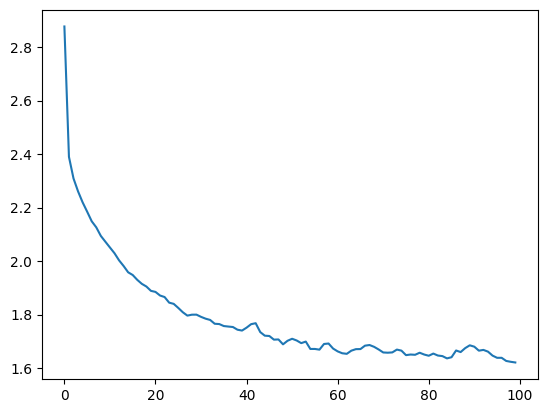

In [43]:
import matplotlib.pyplot as plt

plt.plot(losses);

<p class="task" id="5"></p>

5\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`, `<RU>`, `<EN>`. Выведите на экран количество токенов в полученном словаре.

Модифицируйте датасет `PetsGenDataset` таким образом, чтобы в начало каждого примера добавлялся токен `<RU>`, если это имя питомца на русском, и `<EN>`, если имя на английском. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

- [ ] Проверено на семинаре

In [45]:
df = pd.read_csv('pets_ru_en.csv')
df.head()

,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en


In [46]:
df = df.drop_duplicates(subset='имя', keep='first')

In [47]:
from torchtext.vocab import build_vocab_from_iterator

corpus = []
for name in df['имя']:
    corpus.append(list(name.lower()))

vocab = build_vocab_from_iterator(corpus, specials=['pad', 'sos', 'eos', 'ru', 'en'])

In [48]:
len(vocab.get_stoi())

65

In [49]:
import string
eng_alphabet = string.ascii_lowercase

In [78]:
class PetsGenDatasetRuEn(Dataset):
    def __init__(self, df, vocab):
      def l_f(x):
          if x[0] in eng_alphabet:
              return ['ru'] + ['sos'] + x + ['eos']
          else:
              return ['en'] + ['sos'] + x + ['eos']
      self.df = df['имя'].map(lambda x: list(str(x.lower())))
      self.df = list(self.df.apply(l_f))
      self.vocab = vocab
      self.transform = T.Sequential(
          T.VocabTransform(vocab),
          T.ToTensor(0),
          T.PadTransform(max_length=self.get_max_len() + 1, pad_value=0)
      )

    def __getitem__(self, idx):
      t = self.df[idx]
      return self.transform(t)[:-2], self.transform(t)[2:]

    def __len__(self):
        return len(self.df)

    def get_max_len(self):
        return max(len(x) for x in self.df)

In [79]:
pgd_rn = PetsGenDatasetRuEn(df, vocab)

In [52]:
pgd_rn.get_max_len()

25

In [54]:
from torch.utils.data import DataLoader

dl_train = DataLoader(pgd_rn, batch_size=128, shuffle=True)

In [55]:
x, y = next(iter(dl_train))

In [56]:
x.shape, y.shape

(torch.Size([128, 25]), torch.Size([128, 25]))

<p class="task" id="6"></p>

6\. Модифицируйте функцию для генерации имени, добавив возможность указать первый токен - `<RU>` или `<EN>`. Создайте и обучите модель для генерации имени питомца с указанием языка. Каждые несколько эпох выводите примеры генерации русскоязычных и англоязычных имен при помощи текущего состояния модели . Игнорируйте токен `<PAD>` при расчете ошибки.

- [ ] Проверено на семинаре


In [57]:
def gen_pet_name(lang, model, max_length=10, vocab=vocab):
    pet_name = ''
    softmax = nn.Softmax(dim=1)
    out = model(th.tensor([vocab.get_stoi()[lang]]))
    letter_ind = th.multinomial(softmax(out), num_samples=1)
    letter = vocab.get_itos()[letter_ind]
    pet_name += letter

    for _ in range(max_length):
        out = model(th.tensor([letter_ind]))
        letter_ind = th.multinomial(softmax(out), num_samples=1)
        if letter_ind == vocab.get_stoi()['eos']:
            break
        letter = vocab.get_itos()[letter_ind]
        pet_name += letter
    return pet_name.capitalize()

In [58]:
model = Model(len(vocab.get_stoi()))

n_epochs = 100
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)
losses = []

for epoch in range(n_epochs):
    train_losses = []
    for X_, y_ in dl_train:
        out = model(X_)
        loss = crit(out,th.flatten(y_))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss)
    losses.append(th.tensor(train_losses).mean())
    if epoch % 10 == 0:
        print('epoch=', epoch, 'name= ', gen_pet_name('ru', model))
        print('epoch=', epoch, 'name= ', gen_pet_name('en', model))

epoch= 0 name=  Te
epoch= 0 name=  Вчаааэзш
epoch= 10 name=  Hdblisomke
epoch= 10 name=  Ок
epoch= 20 name=  Sfoinprnhtp
epoch= 20 name=  Плзншаа
epoch= 30 name=  Krxk
epoch= 30 name=  Д
epoch= 40 name=  Brlrд
epoch= 40 name=  Л
epoch= 50 name=  Fafrд
epoch= 50 name=  Ф
epoch= 60 name=  B
epoch= 60 name=  Эяаитшалrsy
epoch= 70 name=  Ciytn
epoch= 70 name=  Рс
epoch= 80 name=  I
epoch= 80 name=  З
epoch= 90 name=  Iy
epoch= 90 name=  Т


## Обратная связь
- [x] Хочу получить обратную связь по решению